In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [84]:
import numpy as np
import pylab as plt

from astropy.io import fits
from astropy.stats import sigma_clip

import sys
sys.path.append('/home/scratch/psalas/LASSI/lassi-analysis_v2')

from grid import regridXYZMasked
from parabolas import rotateData
from lassiAnalysis import maskXYZ
from utils.utils import gridLimits
from zernikies import getZernikeCoeffs
from plotting import surfacePlot
from analyzeActiveSurface import processActiveSurfaceFITSPair

In [85]:
def load_lassi_fits(filename):
    
    hdu = fits.open(filename)
    data = hdu[1].data
    x = data['X']
    y = data['Y']
    z = data['Z']
    
    return x,y,z

def extract_zernikes(refFile, sigFile, n=512, 
                     pFitGuess=[60., 0., 0., -49., 0., 0.], bounds=None, 
                     radialMask=True, rMaskRadius=49.,
                     nZern=36, sigma_clip_diff=False,  **kwargs):
    
    xr, yr, zr = load_lassi_fits(refFile)
    xr.shape = yr.shape = zr.shape = (n,n)
    
    ref_data = maskXYZ(xr, yr, zr, n=n, guess=pFitGuess, radialMask=radialMask, maskRadius=rMaskRadius, **kwargs)

    # Extract the data we will use.
    xrr, yrr, zrr = ref_data['rotated']
    cr = ref_data['parabolaFitCoeffs']
    dzr = ref_data['fitResidual']
    
    xs, ys, zs = load_lassi_fits(sigFile)
    xs.shape = ys.shape = zs.shape = (n,n)
    
    sig_data = maskXYZ(xs, ys, zs, n=n, guess=pFitGuess, radialMask=radialMask, maskRadius=rMaskRadius, **kwargs)

    xs, ys, zs = sig_data['origMasked']
    dzs = sig_data['fitResidual']
    
    print("rms: {}".format(np.nanstd((dzr - dzs)[256-50:256+50,256-50:256+50])))

    # Rotate the signal scan.
    xsr, ysr, zsr = rotateData(xs, ys, zs, cr[4], cr[5])
    xsr.shape = ysr.shape = zsr.shape = (n,n)
    zsr = np.ma.masked_where(zs.mask, zsr)

    # The data has been rotated, but we haven't applied the shifts.
    xrr = xrr - cr[1]
    yrr = yrr - cr[2]
    zrr = zrr - cr[3]
    xsr = xsr - cr[1]
    ysr = ysr - cr[2]
    zsr = zsr - cr[3]

    # Find the grid limits for the reference and signal scans.
    xmin, xmax = gridLimits(xrr, xsr)
    ymin, ymax = gridLimits(yrr, ysr)

    xrrg, yrrg, zrrg = regridXYZMasked(xrr, yrr, zrr, n=n, xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax)
    xsrg, ysrg, zsrg = regridXYZMasked(xsr, ysr, zsr, n=n, xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax)

    # Surface deformation map: reference - signal
    diff = zrrg - zsrg
    diff = diff[::-1] # Flip the signal scan. Required to conform with the way we handle the data.
                      # This should not be required if we handled the data consistently throughout.
    if sigma_clip_diff:
        diff = sigma_clip(diff)

    surfacePlot(xrrg, yrrg, diff, title=False, 
                midPoint=0, vMin=-1e-3, vMax=1e-3, 
                colorbarLabel=False, filename=None)
        
    # Find Zernike coefficients on the surface deformation map.
    fitlist = getZernikeCoeffs(diff.filled(0), nZern, barChart=False, norm='active-surface')
    
    return fitlist

In [48]:
path = "/home/gbtdata/TLASSI_200315/LASSI/"
path2 = "/home/gbtdata/TLASSI_200315/ActiveSurfaceMgr/"

<IPython.core.display.Javascript object>


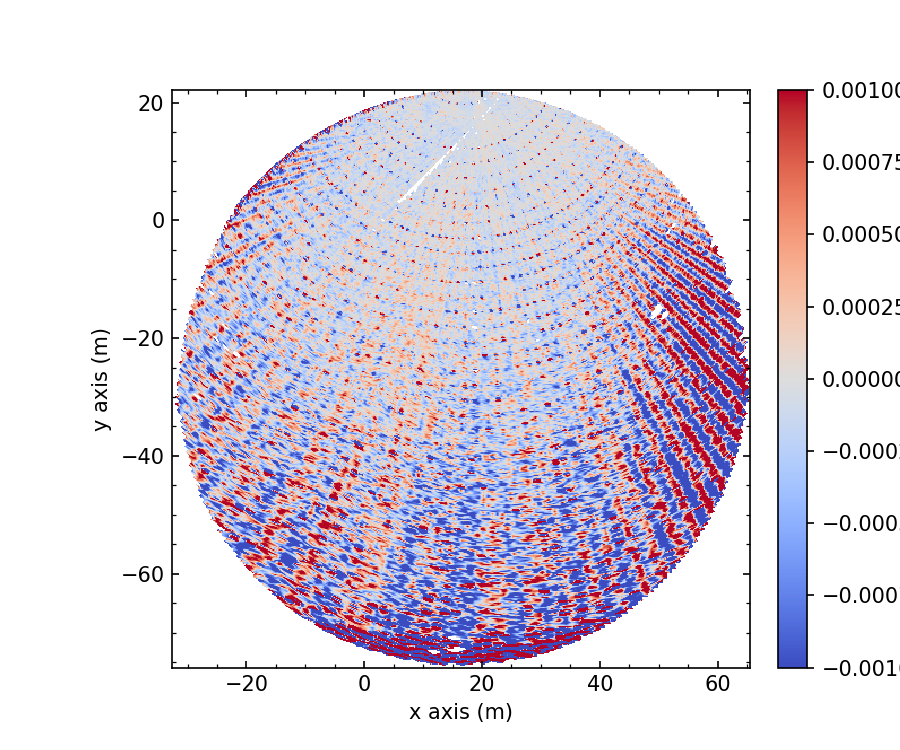

In [30]:
fitslist = extract_zernikes("{0}/2020_03_16_00:51:09.smoothed.fits".format(path), 
                            "{0}/2020_03_16_00:55:30.smoothed.fits".format(path))

<IPython.core.display.Javascript object>


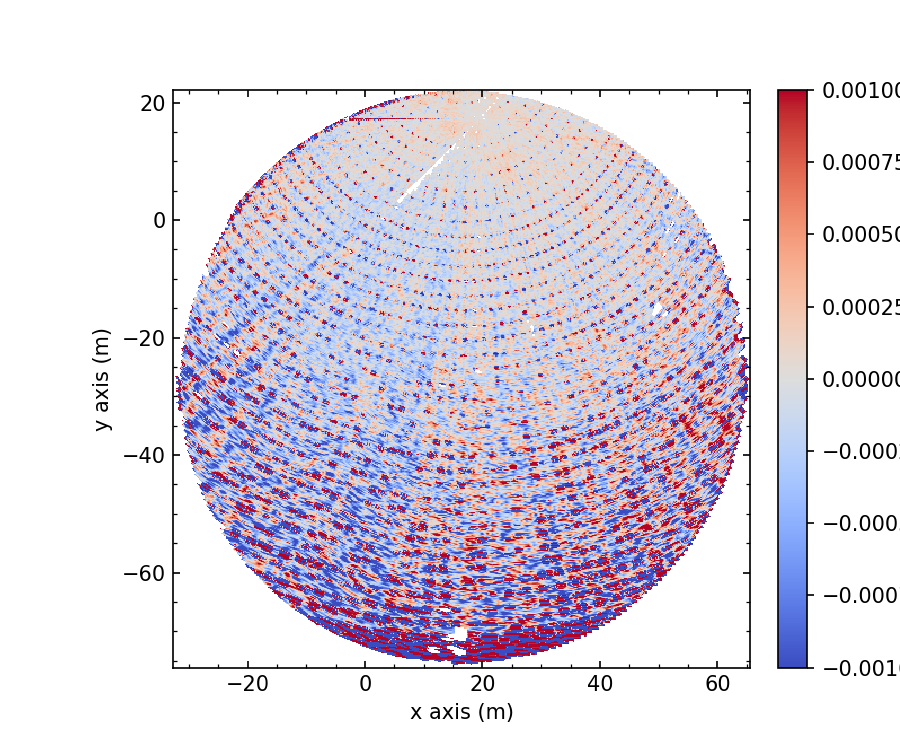

In [31]:
fitslist = extract_zernikes("{0}/2020_03_16_01:00:19.smoothed.fits".format(path), 
                            "{0}/2020_03_16_01:04:36.smoothed.fits".format(path))

rms: 0.0005079917717410572


<IPython.core.display.Javascript object>


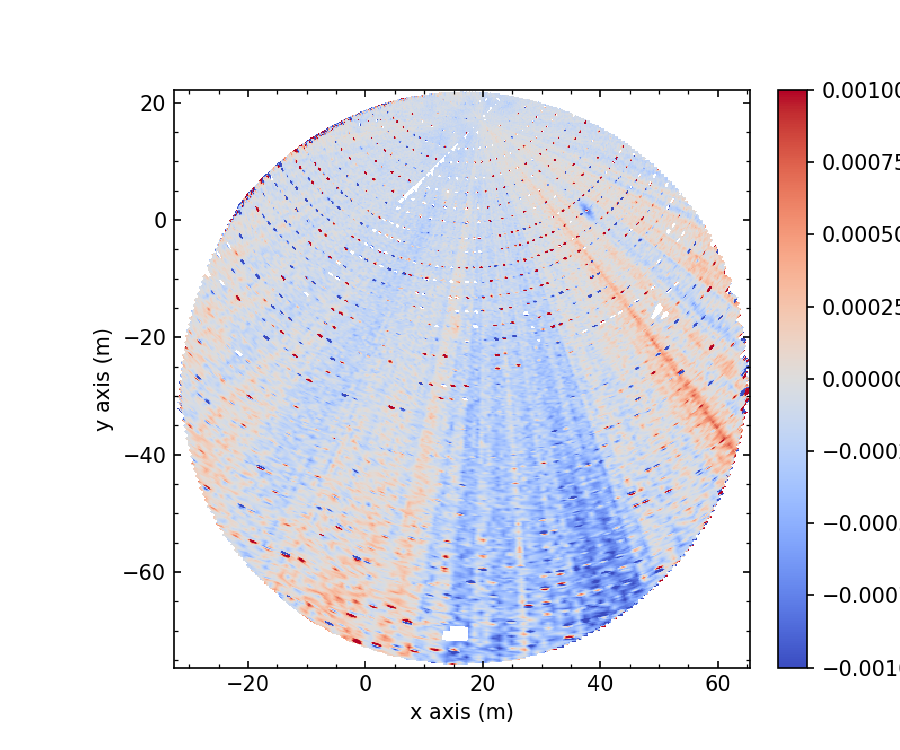

In [42]:
fitslist = extract_zernikes("{0}/2020_03_16_01:12:16.smoothed.fits".format(path), 
                            "{0}/2020_03_16_01:48:22.smoothed.fits".format(path))

Reference file: /home/gbtdata/TLASSI_200315/ActiveSurfaceMgr//2020_03_16_01:12:03.fits
Commanded thermal Zernike coefficients for the reference file:
[('Z1', 0.) ('Z2', 0.) ('Z3', 0.) ('Z4', 0.) ('Z5', 0.) ('Z6', 0.)
 ('Z7', 0.) ('Z8', 0.) ('Z9', 0.) ('Z10', 0.) ('Z11', 0.) ('Z12', 0.)
 ('Z13', 0.) ('Z14', 0.) ('Z15', 0.) ('Z16', 0.) ('Z17', 0.) ('Z18', 0.)
 ('Z19', 0.) ('Z20', 0.) ('Z21', 0.) ('Z22', 0.) ('Z23', 0.) ('Z24', 0.)
 ('Z25', 0.) ('Z26', 0.) ('Z27', 0.) ('Z28', 0.) ('Z29', 0.) ('Z30', 0.)
 ('Z31', 0.) ('Z32', 0.) ('Z33', 0.) ('Z34', 0.) ('Z35', 0.) ('Z36', 0.)]
Signal file: /home/gbtdata/TLASSI_200315/ActiveSurfaceMgr//2020_03_16_01:48:08.fits
Commanded thermal Zernike coefficients for the signal file:
[('Z1',  0.) ('Z2',  0.) ('Z3',  0.) ('Z4', 70.) ('Z5',  0.) ('Z6',  0.)
 ('Z7',  0.) ('Z8',  0.) ('Z9',  0.) ('Z10',  0.) ('Z11',  0.)
 ('Z12',  0.) ('Z13',  0.) ('Z14',  0.) ('Z15',  0.) ('Z16',  0.)
 ('Z17',  0.) ('Z18',  0.) ('Z19',  0.) ('Z20',  0.) ('Z21',  0.)
 ('Z22',

<IPython.core.display.Javascript object>


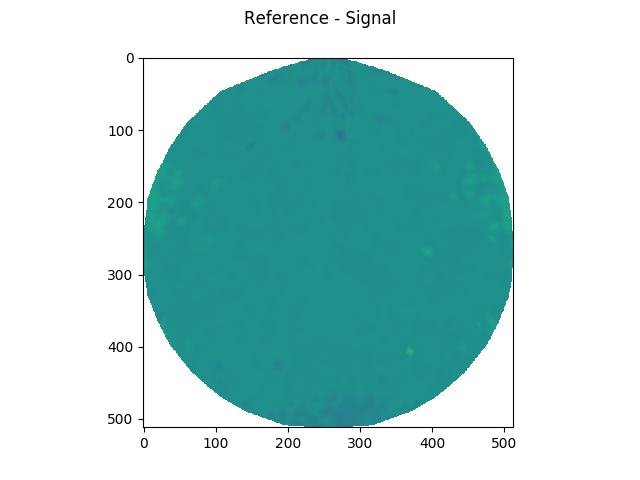

[ 0.00000000e+00 -5.15835172e-01 -1.38153419e-01 -4.81495989e+00
  2.98587398e+01  2.64319091e-02 -2.99659610e-01  9.26525484e-01
 -7.67367139e-01 -1.10604585e+01 -5.21123194e+00 -5.73740607e+00
  1.66196576e+01  1.68869777e+00 -8.25166713e-01  3.14185800e+00
 -5.59121709e+00  1.41890845e+00 -9.23269696e-03 -7.51508531e+00
  3.81971138e+00 -2.17584008e+01  1.35146051e+01  3.95875751e+00
  6.81145395e+00  2.11139883e+00  4.04253973e-01  1.57191581e+00
 -2.12675817e+00  5.21485094e+00  1.71889071e+00 -2.47933469e-01
  2.34682519e+00  7.24954923e-01 -1.26224926e+00 -8.65075720e+00
 -1.45934999e+01]


In [54]:
aas, aar, fitlist = processActiveSurfaceFITSPair("{0}/2020_03_16_01:12:03.fits".format(path2), 
                             "{0}/2020_03_16_01:48:08.fits".format(path2), 
                             column='ABSOLUTE', filterDisabled=True, verbose=True, plot=True)
print(np.array(fitlist)*1e6)

In [57]:
print((np.array(fitlist) - np.array(fitslist))/np.array(fitlist)*100.)

[            nan -1.98804019e+04 -3.00641846e+04 -1.79997692e+03
 -2.68739644e+02 -2.10129858e+05 -5.54907639e+04 -1.64261081e+04
  1.10098922e+03  4.95009221e+02  3.41344301e+02  7.46602823e+02
  1.86688711e+02  7.36007894e+02  1.45781991e+04 -3.77086790e+03
 -9.95212538e+02  6.30885354e+03 -6.89488621e+05  3.12312667e+02
 -4.78432184e+02  2.64018964e+02  1.25568392e+02  1.30855249e+03
  6.98403416e+02  4.05913255e+02  9.33412144e+03  5.21023716e+03
  5.44088751e+02  7.14582720e+02  5.06907018e+02  1.42172469e+03
 -2.83266348e+03  2.00195912e+03 -3.09294927e+03 -2.17605564e+02
  3.55614746e+02]


/home/scratch/psalas/LASSI/lassi-analysis_v2/psalas_lassi_env/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


rms: 0.0005743544189407639


<IPython.core.display.Javascript object>


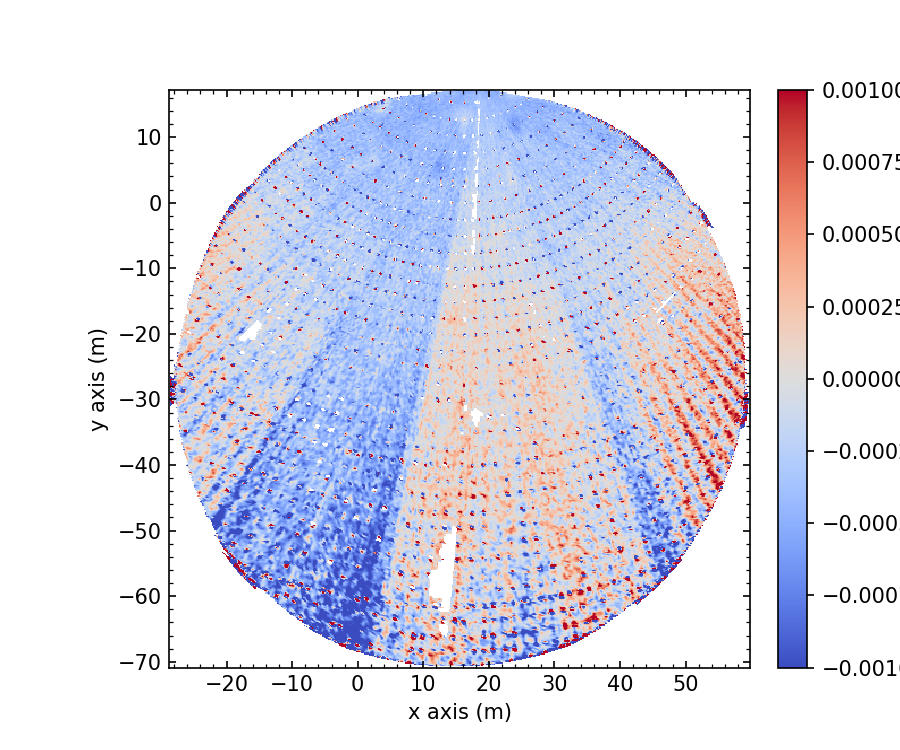

In [59]:
fitslist = extract_zernikes("{0}/2020_03_16_02:21:06.smoothed.fits".format(path), 
                            "{0}/2020_03_16_02:28:31.smoothed.fits".format(path))

Reference file: /home/gbtdata/TLASSI_200315/ActiveSurfaceMgr//2020_03_16_02:20:53.fits
Commanded thermal Zernike coefficients for the reference file:
[('Z1', 0.) ('Z2', 0.) ('Z3', 0.) ('Z4', 0.) ('Z5', 0.) ('Z6', 0.)
 ('Z7', 0.) ('Z8', 0.) ('Z9', 0.) ('Z10', 0.) ('Z11', 0.) ('Z12', 0.)
 ('Z13', 0.) ('Z14', 0.) ('Z15', 0.) ('Z16', 0.) ('Z17', 0.) ('Z18', 0.)
 ('Z19', 0.) ('Z20', 0.) ('Z21', 0.) ('Z22', 0.) ('Z23', 0.) ('Z24', 0.)
 ('Z25', 0.) ('Z26', 0.) ('Z27', 0.) ('Z28', 0.) ('Z29', 0.) ('Z30', 0.)
 ('Z31', 0.) ('Z32', 0.) ('Z33', 0.) ('Z34', 0.) ('Z35', 0.) ('Z36', 0.)]
Signal file: /home/gbtdata/TLASSI_200315/ActiveSurfaceMgr//2020_03_16_02:28:17.fits
Commanded thermal Zernike coefficients for the signal file:
[('Z1',   0.) ('Z2',   0.) ('Z3',   0.) ('Z4', 500.) ('Z5',   0.)
 ('Z6',   0.) ('Z7',   0.) ('Z8',   0.) ('Z9',   0.) ('Z10',   0.)
 ('Z11',   0.) ('Z12',   0.) ('Z13',   0.) ('Z14',   0.) ('Z15',   0.)
 ('Z16',   0.) ('Z17',   0.) ('Z18',   0.) ('Z19',   0.) ('Z20',   0.)
 

<IPython.core.display.Javascript object>


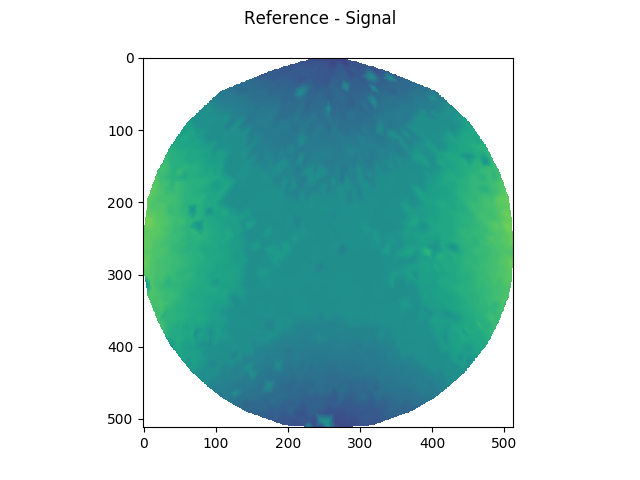

[ 0.00000000e+00  1.10016655e+00  5.62292905e-01  9.55230967e+00
  5.01493146e+02  1.99550501e+01 -4.28548063e+00 -3.12526012e-01
 -2.26818449e+00 -3.55242670e+01 -5.92804431e+00 -1.21715855e+00
 -4.01323193e+00  1.26543051e+01 -1.07327921e-01  6.99659237e+00
 -2.92904258e+00  1.31794624e+00  3.63317759e+00 -8.77522349e-01
  1.46033526e+01 -1.04100144e+01  4.66487688e+00  1.51946145e+01
 -3.85677445e+01 -2.66600492e+00 -1.90711168e+00  1.57764972e+00
 -3.16780936e+00  3.88630633e+00  3.90164658e+00  4.26349637e+00
  1.22446035e-01 -1.40979441e+01  7.94002487e+00  1.38458837e+01
 -1.96619795e+01]


In [61]:
aas, aar, fitlist = processActiveSurfaceFITSPair("{0}/2020_03_16_02:20:53.fits".format(path2), 
                             "{0}/2020_03_16_02:28:17.fits".format(path2), 
                             column='ABSOLUTE', filterDisabled=True, verbose=True, plot=True)
print(np.array(fitlist)*1e6)

rms: 0.0005095559589742963


<IPython.core.display.Javascript object>


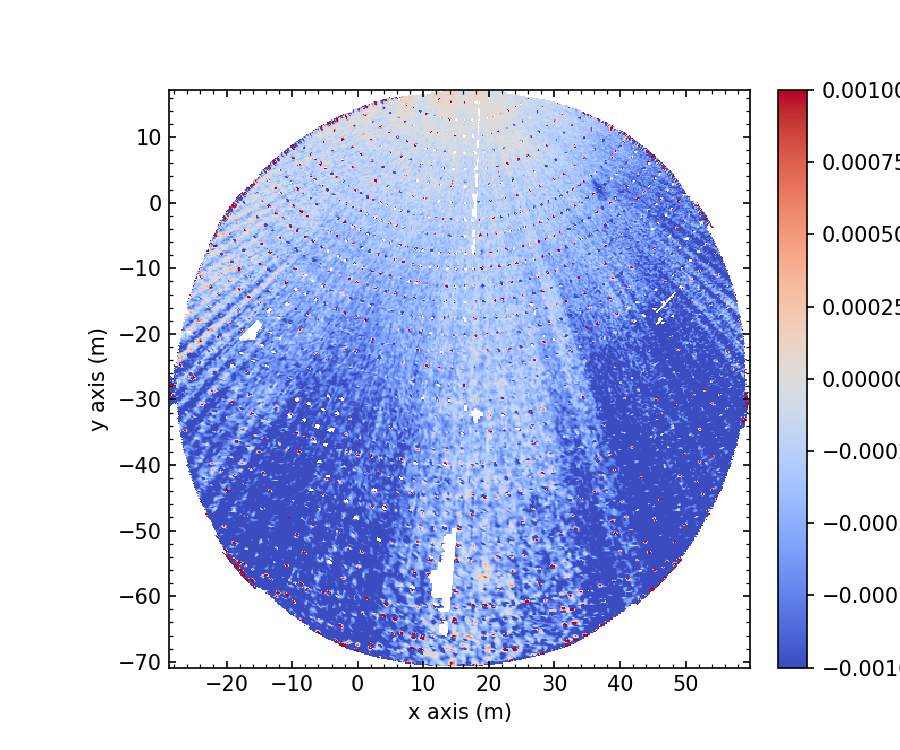

In [62]:
fitslist = extract_zernikes("{0}/2020_03_16_02:21:06.smoothed.fits".format(path), 
                            "{0}/2020_03_16_02:38:25.smoothed.fits".format(path))

rms: 0.14148880542331208


<IPython.core.display.Javascript object>


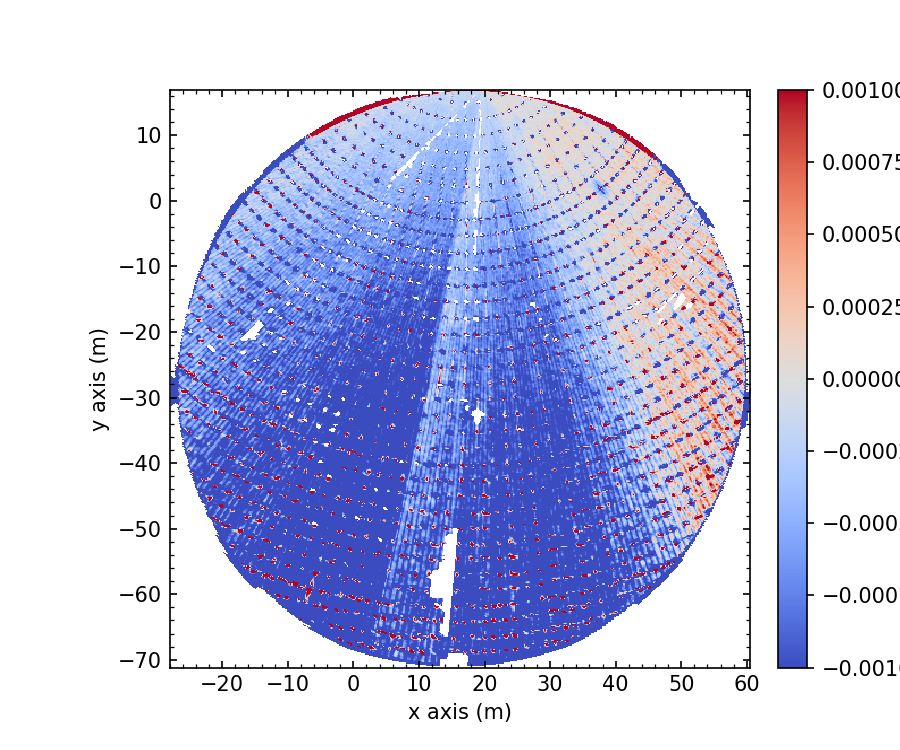

[    0.         -1924.28350716  -921.46995334 -2812.2836551
  -475.64730565 -2984.14036276 -3987.34865175  3883.50497573
 -2650.22252333 -4349.29543747  -977.77553109  1829.27236011
 -1273.48254002 -4971.18937819 -6098.78735962  1644.39679238
 -1482.41501983  5157.94206829 -3819.16775304 -5999.23448002
 -1278.68613013  2557.18793656 -4912.96066131  1339.48790094
 -1606.56639482 -6241.33337008 -7541.7899087   2175.55885679
  2041.67353143 -1495.52793487 -1872.05062214  6466.05402522
 -4491.54801662 -7428.03945265 -1627.74536253  2586.15004785
 -3233.45022781]


In [67]:
fitslist = extract_zernikes("{0}/2020_03_16_01:12:16.smoothed.fits".format(path), 
                            "{0}/2020_03_16_02:45:43.smoothed.fits".format(path))
print(np.array(fitslist)*1e6)

rms: 0.00030646108022081735


<IPython.core.display.Javascript object>


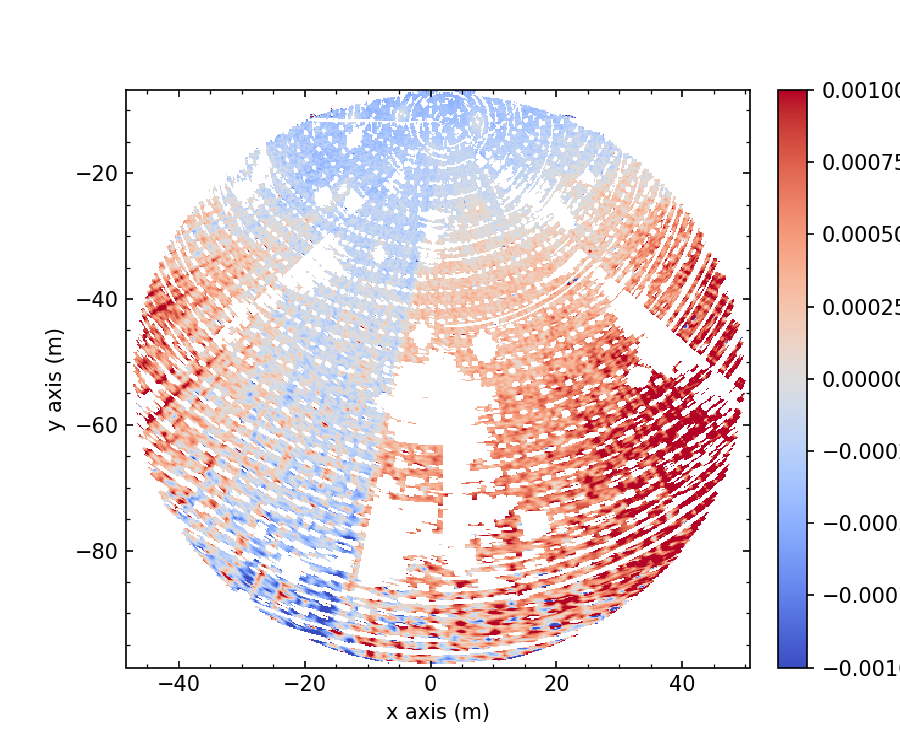

[   0.          141.39117943  280.99912945  176.98667254  331.70572427
   27.41543202  189.90279301 -110.93571387 -136.64532525   -5.90930093
  -35.68494777   52.01254548  -53.93058971  -33.59717669  -44.14592462
   13.92538987  -36.73576913   41.06349562   60.1387362   -57.63338085
   -6.07673589   31.27795053  -83.53357586  -51.73354658  -52.00175746
  -57.98197168  -37.65143047  -64.24832365    0.77125143   13.28433938
   -2.61331857   73.47773522  -47.53824245  -37.84742737   69.42601954
  -66.77603755  -47.66059503]


In [82]:
fitslist = extract_zernikes("{0}/2020_03_16_02:54:59.smoothed.fits".format(path), 
                            "{0}/2020_03_16_03:02:51.smoothed.fits".format(path),
                            **{'sigma':2})
print(np.array(fitslist)*1e6)

Reference file: /home/gbtdata/TLASSI_200315/ActiveSurfaceMgr//2020_03_16_02:54:45.fits
Commanded thermal Zernike coefficients for the reference file:
[('Z1', 0.) ('Z2', 0.) ('Z3', 0.) ('Z4', 0.) ('Z5', 0.) ('Z6', 0.)
 ('Z7', 0.) ('Z8', 0.) ('Z9', 0.) ('Z10', 0.) ('Z11', 0.) ('Z12', 0.)
 ('Z13', 0.) ('Z14', 0.) ('Z15', 0.) ('Z16', 0.) ('Z17', 0.) ('Z18', 0.)
 ('Z19', 0.) ('Z20', 0.) ('Z21', 0.) ('Z22', 0.) ('Z23', 0.) ('Z24', 0.)
 ('Z25', 0.) ('Z26', 0.) ('Z27', 0.) ('Z28', 0.) ('Z29', 0.) ('Z30', 0.)
 ('Z31', 0.) ('Z32', 0.) ('Z33', 0.) ('Z34', 0.) ('Z35', 0.) ('Z36', 0.)]
Signal file: /home/gbtdata/TLASSI_200315/ActiveSurfaceMgr//2020_03_16_03:02:38.fits
Commanded thermal Zernike coefficients for the signal file:
[('Z1',   0.) ('Z2',   0.) ('Z3',   0.) ('Z4', 500.) ('Z5',   0.)
 ('Z6',   0.) ('Z7',   0.) ('Z8',   0.) ('Z9',   0.) ('Z10',   0.)
 ('Z11',   0.) ('Z12',   0.) ('Z13',   0.) ('Z14',   0.) ('Z15',   0.)
 ('Z16',   0.) ('Z17',   0.) ('Z18',   0.) ('Z19',   0.) ('Z20',   0.)
 

<IPython.core.display.Javascript object>


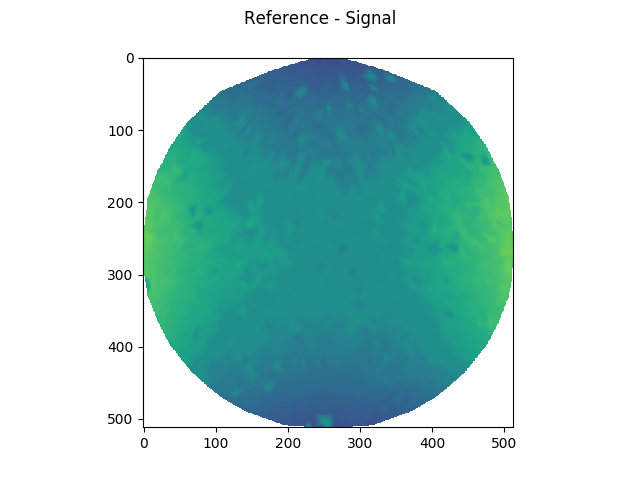

[ 0.00000000e+00 -2.50968048e-01  6.22125400e+00  3.93476350e+00
  4.96845711e+02  8.86558187e+00 -2.20692509e+01  3.61493171e+00
  1.19067587e+01 -2.69429732e+01 -4.20251068e+00  2.52934816e+01
 -8.02983888e+00  1.24245949e+01  5.04468668e+00  5.81898146e+00
 -3.44268140e+00 -2.89861657e+00 -8.19506075e+00 -6.94565163e+00
  1.37321576e+01  4.80306159e+00 -1.14589616e+01  5.00949072e+00
 -3.36014051e+01  3.32514108e+00 -5.67989687e+00  3.14349063e+00
 -5.25081449e+00 -1.33009338e-01  7.15862402e-01  3.50536571e+00
  1.24263556e+01 -1.30700202e+01  6.42371486e+00  1.47636036e+01
 -2.24296650e+01]


In [69]:
aas, aar, fitlist = processActiveSurfaceFITSPair("{0}/2020_03_16_02:54:45.fits".format(path2), 
                             "{0}/2020_03_16_03:02:38.fits".format(path2), 
                             column='ABSOLUTE', filterDisabled=True, verbose=True, plot=True)
print(np.array(fitlist)*1e6)

rms: 0.0005227737857751426


<IPython.core.display.Javascript object>


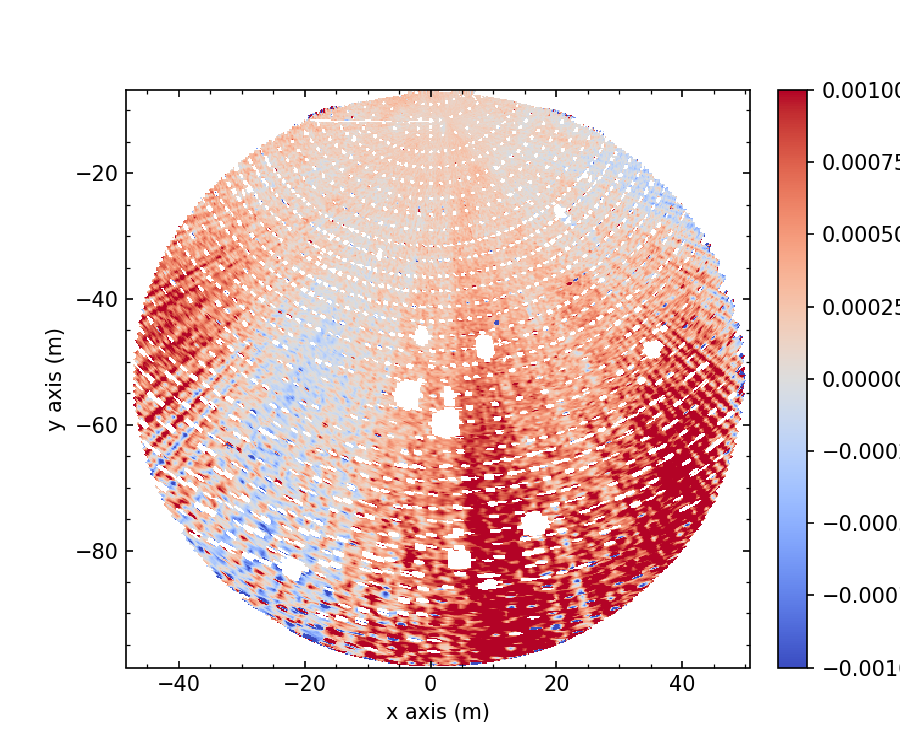

[   0.          329.75569999  211.58971464  310.17832282  -39.50805913
   41.55597482  410.48412728 -254.87385934 -230.9611185   -11.64655109
  -80.13253702  135.6459531   -76.12149428  -77.00484592  -23.16426469
   23.25841218  -62.38716963 -100.17540511  -24.62097979   24.99727268
   67.47525427   87.3407807  -213.6546024  -196.86142192 -310.18689599
 -199.31935606  -78.38630091  -56.87909172   80.89189587 -162.86315932
 -117.02587209  -65.2132284  -130.93653778 -107.18349511  -39.02873295
    9.78919013  -59.37319401]


In [73]:
fitslist = extract_zernikes("{0}/2020_03_16_02:54:59.smoothed.fits".format(path), 
                            "{0}/2020_03_16_03:12:22.smoothed.fits".format(path))
print(np.array(fitslist)*1e6)

rms: 0.00037589783447749913


<IPython.core.display.Javascript object>


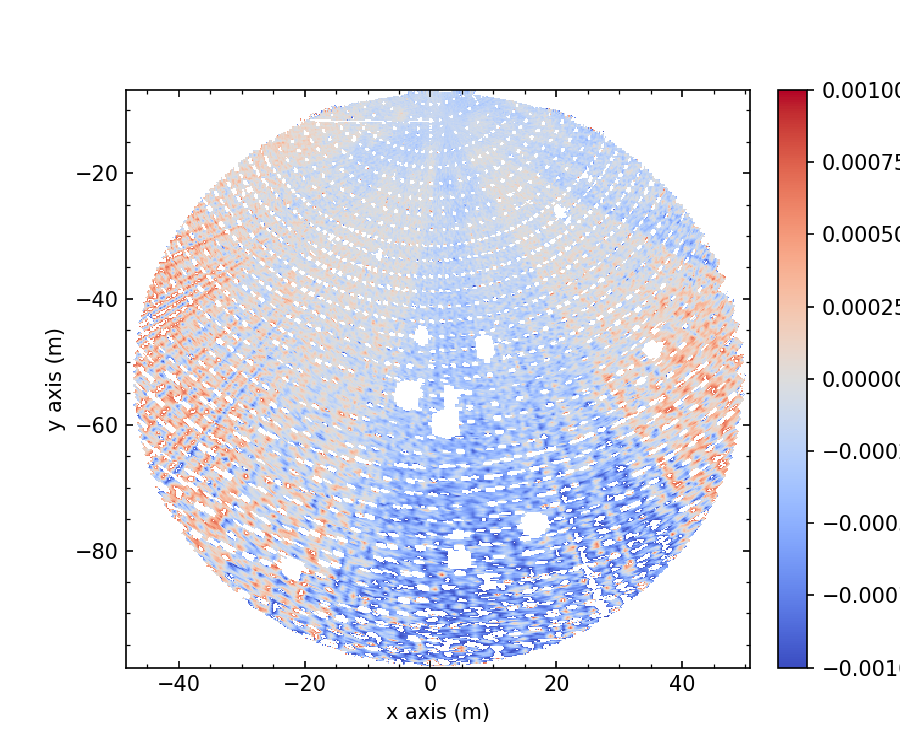

[   0.         -120.99165487  -98.98738107 -151.9610693   231.9956131
   61.85767066  -43.3760671    97.91029651   42.67867574   80.41778389
   27.18301507   14.20814736  -78.02099857  -20.3861593    78.63624067
   10.63317978   62.57440745  -36.25166798  -29.37698311   -5.48370642
    2.22590893  -12.90891648   51.09799425  -19.69713757  -25.83018351
    8.20241929    8.18256673   14.21186428   26.68139302   14.10496883
  -72.68199064   -8.93473458   57.88276958   -5.05515577    9.12009975
   20.27376161    4.58392279]


In [87]:
fitslist = extract_zernikes("{0}/2020_03_16_03:19:50.smoothed.fits".format(path), 
                            "{0}/2020_03_16_03:27:25.smoothed.fits".format(path),
                           rMaskRadius=49., sigma_clip_diff=True, **{'sigma':3})
print(np.array(fitslist)*1e6)

Reference file: /home/gbtdata/TLASSI_200315/ActiveSurfaceMgr//2020_03_16_03:19:37.fits
Commanded thermal Zernike coefficients for the reference file:
[('Z1', 0.) ('Z2', 0.) ('Z3', 0.) ('Z4', 0.) ('Z5', 0.) ('Z6', 0.)
 ('Z7', 0.) ('Z8', 0.) ('Z9', 0.) ('Z10', 0.) ('Z11', 0.) ('Z12', 0.)
 ('Z13', 0.) ('Z14', 0.) ('Z15', 0.) ('Z16', 0.) ('Z17', 0.) ('Z18', 0.)
 ('Z19', 0.) ('Z20', 0.) ('Z21', 0.) ('Z22', 0.) ('Z23', 0.) ('Z24', 0.)
 ('Z25', 0.) ('Z26', 0.) ('Z27', 0.) ('Z28', 0.) ('Z29', 0.) ('Z30', 0.)
 ('Z31', 0.) ('Z32', 0.) ('Z33', 0.) ('Z34', 0.) ('Z35', 0.) ('Z36', 0.)]
Signal file: /home/gbtdata/TLASSI_200315/ActiveSurfaceMgr//2020_03_16_03:27:11.fits
Commanded thermal Zernike coefficients for the signal file:
[('Z1',   0.) ('Z2',   0.) ('Z3',   0.) ('Z4', 150.) ('Z5',   0.)
 ('Z6',   0.) ('Z7',   0.) ('Z8',   0.) ('Z9',   0.) ('Z10',   0.)
 ('Z11',   0.) ('Z12',   0.) ('Z13',   0.) ('Z14',   0.) ('Z15',   0.)
 ('Z16',   0.) ('Z17',   0.) ('Z18',   0.) ('Z19',   0.) ('Z20',   0.)
 

<IPython.core.display.Javascript object>


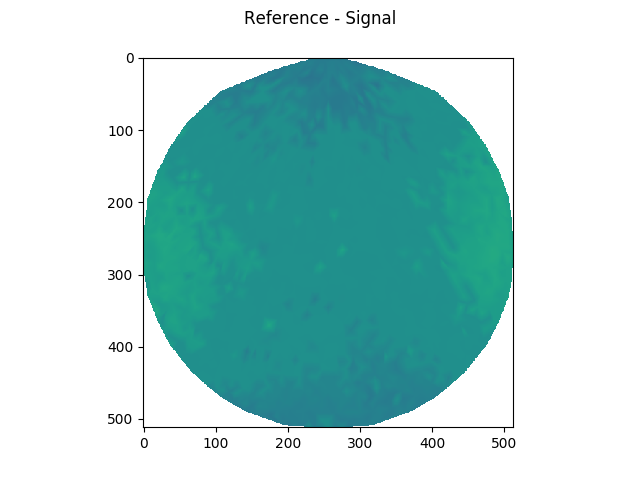

[  0.           4.39556889   1.97168609   2.8623093  162.51285227
   3.87371886 -26.75566652   8.33532378  13.91932118 -10.46724576
  -5.06993592  22.65558731   6.96635972  -0.82538635  -3.47164111
  -4.44509176  -1.69852726  -5.26601334   5.89946379 -16.04684994
   5.23873498  10.88177413  14.24537428 -11.10806385 -39.15443599
  -5.13736143   4.02106344   3.39611297  -1.58776497   0.73619937
  11.12233726  -5.88122886  -3.71713759  -0.42699332  -0.21536404
  -7.91131815 -12.70364944]


In [75]:
aas, aar, fitlist = processActiveSurfaceFITSPair("{0}/2020_03_16_03:19:37.fits".format(path2), 
                             "{0}/2020_03_16_03:27:11.fits".format(path2), 
                             column='ABSOLUTE', filterDisabled=True, verbose=True, plot=True)
print(np.array(fitlist)*1e6)

rms: 0.0005715035055847715


<IPython.core.display.Javascript object>


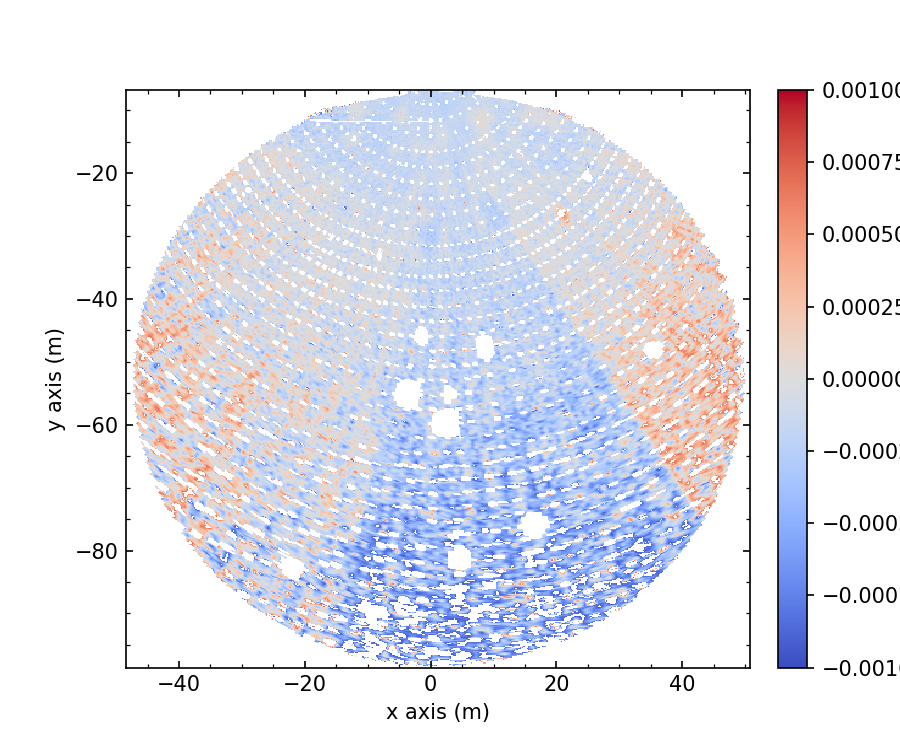

[   0.         -111.70522337  -36.67049589 -131.64742865  220.82236329
   59.79321337  -82.42326102   70.48324306   63.85997733   60.49728731
   -2.91943089   50.70551973  -62.57925862  -12.29740838   35.7888291
    2.97828617   35.31773223  -22.93019474  -57.33903076    7.47252648
    3.51459343   30.05162176   31.91463833  -28.16636667  -43.82740123
  -12.29217197    0.36889632   31.8058313    21.93161641  -26.4791391
  -48.90372164  -26.27536116   19.65539997   -0.98773222    0.74530503
   -6.71787629   45.430809  ]


In [88]:
fitslist = extract_zernikes("{0}/2020_03_16_07:00:20.smoothed.fits".format(path), 
                            "{0}/2020_03_16_07:07:49.smoothed.fits".format(path),
                           rMaskRadius=49., sigma_clip_diff=True, **{'sigma':3})
print(np.array(fitslist)*1e6)

rms: 0.0011662144695024303


<IPython.core.display.Javascript object>


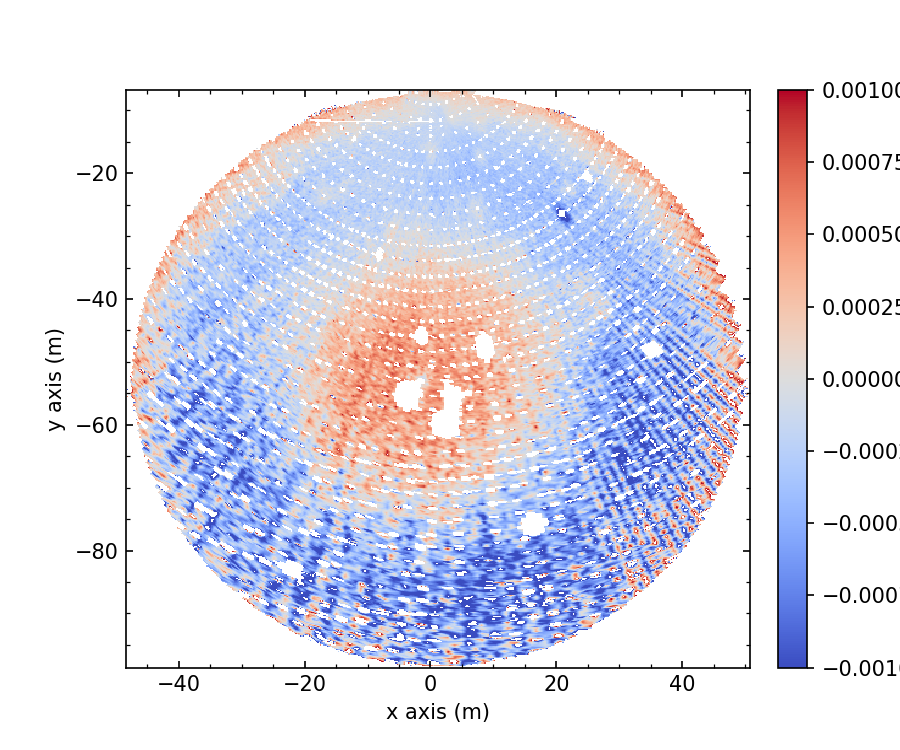

[   0.         -163.03817558  -42.44728342 -205.82611539   47.37882676
 -139.45284132   -3.88502763   39.47980149  127.38583246  -53.99551058
  -26.69908473  -38.33416968   89.25767984  468.03026247   19.44081548
   25.48279862  -60.76996716  -27.18598314  -51.22897807   48.0745566
   12.47293044  -16.24949597    5.89136421   50.01971611  -24.59686271
  -24.47897528  -50.68922772   -5.49014902  -30.23840376   17.2874831
   35.71772837  -15.1539933     0.49636408   12.13360962   -3.11763198
   58.0253821   -13.24188009]


In [95]:
fitslist = extract_zernikes("{0}/2020_03_16_09:01:35.smoothed.fits".format(path), 
                            "{0}/2020_03_16_09:09:14.smoothed.fits".format(path),
                           rMaskRadius=52., sigma_clip_diff=True, **{'sigma':3})
print(np.array(fitslist)*1e6)

rms: 0.0011873642131241058


<IPython.core.display.Javascript object>


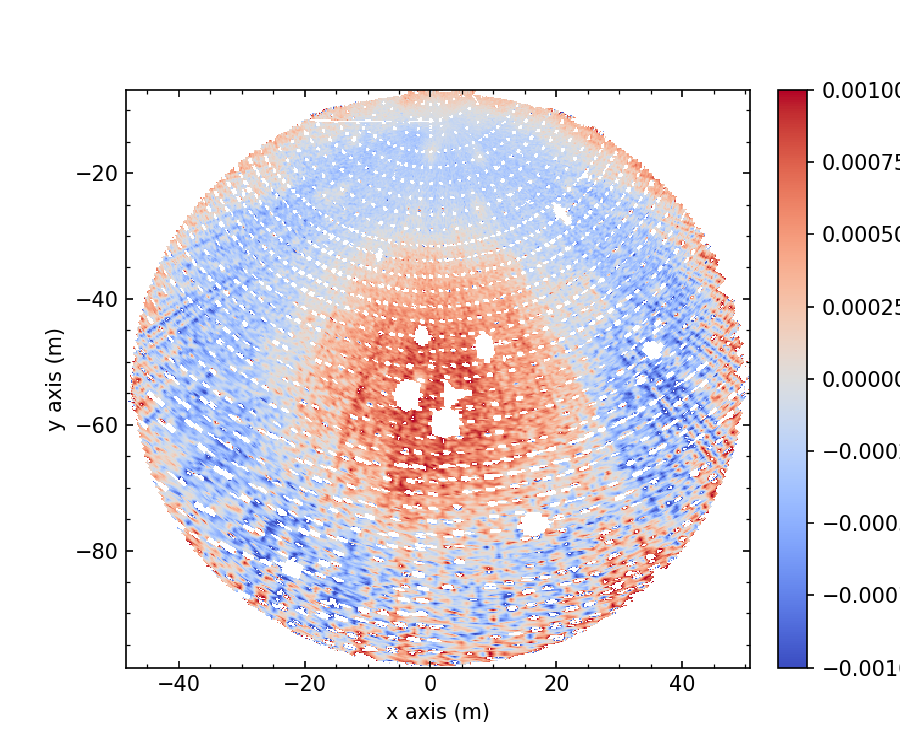

[   0.           -9.03884052   42.74053913   59.63658807  -80.02522671
 -183.9443472    48.59827202  -51.32602295   32.16391966  -88.20473894
   -9.53696775  -25.40827974  106.77415814  450.16171739  -29.75470302
  -22.36825186  -12.8229244    26.30463735   -1.01050317   27.07191043
    2.66693283   14.33945541   -0.68565821   31.97368075  -17.26107326
  -10.18967412  -24.96824839   -4.83954142  -35.16093068   31.81152023
   41.09499562    1.64237977  -16.39657305   -4.21239201   -4.20916718
   10.13345929  -34.79407786]


In [94]:
fitslist = extract_zernikes("{0}/2020_03_16_05:22:24.smoothed.fits".format(path), 
                            "{0}/2020_03_16_05:30:05.smoothed.fits".format(path),
                           rMaskRadius=52., sigma_clip_diff=True, **{'sigma':3})
print(np.array(fitslist)*1e6)